# Inferring Causal Effects from Observational Data

**Outline**

* [Introduction](#intro)
* [Propensity Score Matching](#propensity)
    * [What are propensity scores for](#whatfor)
    * [An illustrative example](#example)
    * [How do we access whether if the matching works well or not?](#accessresult)
    * [Matching v.s Regression](#proscons)
    * [General Procedure](#procedure)
    * [Implementing Propensity Score Matching](#matchit)
        * [Matching Methods](#matchingmethod)
        * [Checking Balance](#balance)
        * [Conducting Analyses after Matching](#analysis)
* [Inferring the effect of an event using CausalImpact by Kay Brodersen](#causalimpact)
    * [Introduction](#intro2)
    * [An Example](#causalimpactexample)     
* [Reference](#refer)    


---

## <a id='intro'>Introduction</a>

We all know that correlation doesn't mean causation. To infer the causal relation, one way we can do is by conducting experiments. We can randomly separate our subject into treatment and control and then see if the outcome variable is different between the two groups.

However, how do we inferring causal effects if we can not conduct experiments or if we want to infer from observational data? One example when an experiment can not be done. If we want to know the impact of profile upload to other metrics such as engagement rate/contribution rate...etc, how can we conduct an experiment to know it? We can select a sample of people who don't have a profile picture and separate them into treatment and control. In the treatment group, we encourge them to update their profile picture, whereas in the control group we don't do anything. However, in the control group, we can not prevent them from uploading their profile picture. This can be one case when an experiment can not be done. Casual inference from observatinoal data can be a way to deal with this problem.

## <a id='propensity'>Propensity Score Matching</a>


* [Video: An intuitive introduction to Propensity Score Matching](https://www.youtube.com/watch?v=ACVyPp1Fy6Y)
* [Wiki: Propensity Score Matching](https://en.wikipedia.org/wiki/Propensity_score_matching)

### <a id='whatfor'>What are propensity scores for?</a>

There are situations when we want to know the causal effect of something but we can't run an experiment for many reasons like budget, time, or other resources. 

Propensity scores matching(PSM) is a statistical matching technique that attempts to estimate the effect of a treatment by accounting for the covariates that predict receiving the treatment. PSM attempts to reduce the bias due to confounding variables that could be found in an estimate of the treatment effect obtained from simply comparing outcomes among units that received the treatment versus those that did not.

### <a id='example'>An illustrative example</a>

An NGO has built health clinics in several villages in order to reduce the infant mortality rate. Those villages were not chosen randomly when they first decided which village they want to build those clinics.

The goal of the analysis is to **estimate the effect of the program on infant mortality from observational data**.

In [6]:
library(dplyr)

In [9]:
data = data.frame(T=c(1,1,1,1,0,0,0,0,0),
                 imrate=c(10,15,22,19,25,19,4,8,6))
data

T,imrate
1,10
1,15
1,22
1,19
0,25
0,19
0,4
0,8
0,6


> **Estimate the effect in the most naive (but wrong) way**

To estimate the effect, the most naive way we can do is by simply comparing the average mortality rate of villages that have clinic versus those that don't. More specifically, it would be:

In [10]:
data %>% group_by(T) %>% summarise(mean(imrate))

T,mean(imrate)
0,12.4
1,16.5


Surprising, it seems that the villages with a clinic actually turns out to have a higher average infant mortality rate and we might think about drawing the conclusion that clinics are increasing infant mortality.

However, we all know that we shouldn't draw this conclusion because it's only correlation rather than causal. While there is a positive correlation between having clinic or not to infant mortality rate, it doesn't mean that not having the clinic would lower the mortality rate. There may be confounding variables that effect both having clinic or not and infant mortality rate.
Let's include some potential confounding variable and take a look again.

In [11]:
data2 = data.frame(village=seq(1,9),
                  T=c(1,1,1,1,0,0,0,0,0),
                  imrate=c(10,15,22,19,25,19,4,8,6),
                  povrate=c(.5, .6, .7, .6, .6, .5, .1, .3, .2),
                  pcdocs=c(.01, .02, .01, .02, .01, .02, .04, .05, .04))
data2
# povrate: poverty rate
# pcdocs: the number of doctors per capita

village,T,imrate,povrate,pcdocs
1,1,10,0.5,0.01
2,1,15,0.6,0.02
3,1,22,0.7,0.01
4,1,19,0.6,0.02
5,0,25,0.6,0.01
6,0,19,0.5,0.02
7,0,4,0.1,0.04
8,0,8,0.3,0.05
9,0,6,0.2,0.04


> **The Basic Idea**

1. **Create a new control group**:
    For each observation in the treatment group (T=1), select the control observation that looks most like it based on the selction variable(aka, background characteristics)

2. **Compute the treatment effect**:
    Compare the average outcome in the treatment group with the average outcome in the new control group
    

For step 1, if we only have 1 charactistics, then, it would be pretty straight to match it. For example, the control observation for village 1 would be village 6, following by (village 2, village 5), (village 3, village 5) and (village 4, village 5). Then we can estimate the effect by computing the average mortaliy rate for treatment and the new control group by our manual matching process.

However, if we want to match according to multiple characteristics, there would be cases when we are not sure which one we should use to match it. We might want to have a way to match it based on some weights. This is actually what logistic regression is trying to do. 

The way we are going to match is can be described as follows
1. Fit a logistic regression with to estimate $Prob(T=1|X_1, X_2, \dots, X_k)$
2. Use the probability/score to match the control observation for each of the records in the treatment.
3. Compute the treatment effect using the treatment and the new control group as the estimated causal effect.

In [42]:
my_model = glm(T~povrate+pcdocs, family=binomial, data=data2)
predict_fit = predict(my_model, data2 %>% select(-village), type="response")

In [43]:
data2$propensity_score = predict_fit
data2

village,T,imrate,povrate,pcdocs,propensity_score
1,1,10,0.5,0.01,0.416571243
2,1,15,0.6,0.02,0.735817065
3,1,22,0.7,0.01,0.928451644
4,1,19,0.6,0.02,0.735817065
5,0,25,0.6,0.01,0.752714034
6,0,19,0.5,0.02,0.395161945
7,0,4,0.1,0.04,0.001653370
8,0,8,0.3,0.05,0.026802930
9,0,6,0.2,0.04,0.007010716


Now, with the predicted score, we can match the new control for each records in the treatment taking all the background characteristics into account. This process is called **propensity score matching**.

Let's calcualte the estimated causal effect:

In [47]:
data2$match = c(6,5,5,5,"matched","matched",NA,NA,NA)
data2 %>% filter(!is.na(match)) %>% group_by(T) %>% summarise(mean(imrate))

T,mean(imrate)
0,22.0
1,16.5


We can clearly see that the having a clinic can actually help decrease the infant mortality rate.

### <a id='accessresult'>How do we access whether if the matching works well or not?</a>

Idealy, we want the control group to look a lot like the treatment group based on the pre-existing charateristics, but sometimes we don't have many control group observations that look like the treatement group observations. In those situations, we shouldn't put faith in our matching estimates and there are a few ways that we can recognize these situations.

1. **Look at the covariate balance between the treatment and new control group**: we can simply compare the distributions of the features (or covariates) in the treatment group and the constructed control group. They should be similar. If not, we shouldn't trust our matching result.

2. **Compare the distributions of the propensity scores in the treatment group and new control group**: The distribution should be similar. If not, we shouldn't trust our matching result.

3. **Compare distributions of the propensity scores in the treatment and the original control group**: if the distribution isn't overlap very well, then the matching won't work very well; if they overlap perfectly, then then matching isn't necessary. We can just compare the average outcomes directly.

### <a id='proscons'>Matching v.s Regression</a>

Propensity Score Matching and multiple regression solve very similar problems. They both try to estimate the effects on the result taking into the underlying charateristics, that can be confounding varaibles, into account. While PSM is very similar to simply running a regression and controlling for these variables, there are some important differences:
 
* **Pros of Matching**
    * Not as sensitive to the functional form of the covariates
    * Easier to assess whether it's working
    * If your treatment is fairly rare, you may have a lot of control observations that are obviously not comparable. In other words, we may have a large number of control observations that are clearly not relevant that they would never be chosen for the treatment. Matching is able to just ignore them while those records might have some influence on the regression result.
    * More straight-forward to explain.
* **Procs of Regression**
    * Sometimes our outcome, or the response that we care about might not be binary. For example, it can be # times people visit a store. Regression can let us estimate effect of a continuous treatment.
    * Shos us the effect of all the variables
    * Let us estimate the interactions of treatment with covariates
    * There are so many ways to use propensity scords that it's hard to replicate analysis and we have to make somewaht arbitrary decisions about how to apply it.

### <a id='procedure'>General Procedure</a>

1. Run logistic regression:
    * Dependent variable: Y = 1, if participate; Y = 0, otherwise.
    * Choose appropriate confounders (variables hypothesized to be associated with both treatment and outcome)
    * Obtain propensity score: predicted probability (p) or log[p/(1 − p)].
2. Check that propensity score is balanced across treatment and comparison groups, and check that covariates are balanced across treatment and comparison groups within strata of the propensity score. 
    * Use standardized differences or graphs to examine distributions
3. Match each participant to one or more nonparticipants on propensity score
    * Nearest neighbor matching
    * Caliper matching: comparison units within a certain width of the propensity score of the treated units get matched, where the width is generally a fraction of the standard deviation of the propensity score
    * Mahalanobis metric matching in conjunction with PSM
    * Stratification matching
    * Difference-in-differences matching (kernel and local linear weights)
    * Exact matching
4. Verify that covariates are balanced across treatment and comparison groups in the matched or weighted sample
5. Multivariate analysis based on new sample
    * Use analyses appropriate for non-independent matched samples if more than one nonparticipant is matched to each participant
   * Note: When you have multiple matches for a single treated observation, it is essential to use Weighted Least Squares rather than OLS.

### <a id='matchit'>Implementing Propensity Score Matching</a>

* [Reference: Propensity Score Matching](https://sejdemyr.github.io/r-tutorials/statistics/tutorial8.html)
* [Offical MatchIt Document](https://r.iq.harvard.edu/docs/matchit/2.4-20/)

In [1]:
library(MatchIt)

Warning message:
“package ‘MatchIt’ was built under R version 3.4.3”

The variables in this data set include 
* **participation in the job training program** (treat, which is equal to 1 if participated in the program, and 0 otherwise)
* **age** (age)
* **years of education** (educ)
* **race** (black which is equal to 1 if black, and 0 otherwise; hispan which is equal to 1 if hispanic, and 0 otherwise) 
* **marital status** (married, which is equal to 1 if married, 0 otherwise)
* **high school degree** (nodegree, which is equal to 1 if no degree, 0 otherwise)
* **1974 real earnings** (re74)
* **1975 real earnings** (re75)
* the main outcome variable, **1978 real earnings** (re78).

The goal of this causal analysis is to find whether if participating in the program would effect their real earning in 1978.

In [107]:
data(lalonde)
head(lalonde)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0,0,9930.0460
NSW2,1,22,9,0,1,0,1,0,0,3595.8940
NSW3,1,30,12,1,0,0,0,0,0,24909.4500
NSW4,1,27,11,1,0,0,1,0,0,7506.1460
NSW5,1,33,8,1,0,0,1,0,0,289.7899
NSW6,1,22,9,1,0,0,1,0,0,4056.4940


#### Naive Way
If we compare the average real earning in 1978 by participation in the job training program or not directly, it would seem that participate in the program would lead to lower earning. However, in some sense we know that it's not true because people who particpate in the program are those who usually have lower earning at the first place. That's why we need to use causal analysis to have a better estimate.

In [7]:
lalonde %>% group_by(treat) %>% summarise(mean(re78))

treat,mean(re78)
0,6984.170
1,6349.144


#### <a id='matchingmethod'>Matching Methods</a>

The parameters for **matchit** function
* **method**: exact, subclass, nearest, optimal, full, ...etc
* **ratio**: the ratio of the treatment and new control group. If ratio=2, #treatments : #control = 1:2
* **m.order**: default "largest", another option is "smallest"
* **distance**: default "logit". The method used to calculate propensity score

> **Exact Match**

* The simplest version of matching is exact. This technique matches each treated unit to all possible control units with exactly the same values on all the covariates, forming subclasses such that within each subclass all units (treatment and control) have the same covariate values. 

In [8]:
m.out <- matchit(treat ~ educ + black + hispan, data = lalonde, method = "exact")
m.out


Call: 
matchit(formula = treat ~ educ + black + hispan, data = lalonde, 
    method = "exact")

Exact Subclasses: 25

Sample sizes:
          Control Treated
All           429     185
Matched       376     184
Unmatched      53       1


Using exact match, the result shows that almost all the observations in the treatment group can be matched (184/185) using these 3 covariates. There are 376 observations in the control group that are used to form a new control group. (1 records can be used multiple times)

> **Subclassification**

* The syntax below forms 6 subclasses, which is the default number of subclasses, based on a distance measure (the propensity score) estimated using logistic regression. By default, each subclass will have approximately the same number of treated units.

In [15]:
m.out <- matchit(treat ~ re74 + re75 + educ + black + hispan + age, 
                   data = lalonde, method = "subclass")
m.out


Call: 
matchit(formula = treat ~ re74 + re75 + educ + black + hispan + 
    age, data = lalonde, method = "subclass")

Sample sizes by subclasses:

           Control Treated
All            429     185
Subclass 1     344      31
Subclass 2      26      31
Subclass 3      17      30
Subclass 4      21      31
Subclass 5       7      31
Subclass 6      14      31


> **Nearest Neighbor Matching**

* Based on distance of the propensity score estimated using logis regression (distance='logit' by default) to the actual outcome, choose the nearest neighbor, with the order specified by the m.order command (default=largest to smallest)
* Only match at most one record from control to treatment. At each matching step we choose the control unit that is not yet matched but is closest to the treated unit on the distance measure.

In [106]:
m.out <- matchit(treat ~ re74 + re75 + educ + black + hispan + age, 
                   data = lalonde, method = "nearest") #ratio = 2,  m.order='largest' (default, another option is 'smallest')
m.out


Call: 
matchit(formula = treat ~ re74 + re75 + educ + black + hispan + 
    age, data = lalonde, method = "nearest")

Sample sizes:
          Control Treated
All           429     185
Matched       185     185
Unmatched     244       0
Discarded       0       0


> **Optimal**

* The default nearest neighbor matching method in MATCHIT is *greedy* matching, where the closest control match for each treated unit is chosen one at a time, without trying to minimize a global distance measure. In contrast, *optimal* matching finds the matched samples with the smallest average absolute distance across all the matched pairs. 
* find that greedy and optimal matching approaches generally choose the same sets of controls for the overall matched samples, but optimal matching does a better job of minimizing the distance within each pair. In addition, optimal matching can be *helpful when there are not many appropriate control matches for the treated units*.

In [26]:
m.out <- matchit(treat ~ re74 + re75 + age + educ, data = lalonde, 
                   method = "optimal", ratio = 2)
m.out

Warning message in optmatch::fullmatch(d, min.controls = ratio, max.controls = ratio, :
“Without 'data' argument the order of the match is not guaranteed
    to be the same as your original data.”


Call: 
matchit(formula = treat ~ re74 + re75 + age + educ, data = lalonde, 
    method = "optimal", ratio = 2)

Sample sizes:
          Control Treated
All           429     185
Matched       370     185
Unmatched      59       0
Discarded       0       0


> **Other Matching Methods**

* [Full Matching](https://r.iq.harvard.edu/docs/matchit/2.4-20/Full_Matching.html)
* [Generic Matching](https://r.iq.harvard.edu/docs/matchit/2.4-20/Genetic_Matching.html)
* [Coarsened Exact Matching](https://r.iq.harvard.edu/docs/matchit/2.4-20/Coarsened_Exact_Matchi.html)

#### <a id='balance'>Checking Balance</a>

In [42]:
# not sure how to interpret the result
summary(m.out, standardize = TRUE)  #, standardize = TRUE


Call:
matchit(formula = treat ~ re74 + re75 + educ + black + hispan + 
    age, data = lalonde, method = "nearest")

Summary of balance for all data:
         Means Treated Means Control SD Control Std. Mean Diff. eCDF Med
distance        0.5658        0.1872     0.2308          1.7919   0.4017
re74         2095.5737     5619.2365  6788.7508         -0.7211   0.2335
re75         1532.0553     2466.4844  3291.9962         -0.2903   0.1355
educ           10.3459       10.2354     2.8552          0.0550   0.0228
black           0.8432        0.2028     0.4026          1.7568   0.3202
hispan          0.0595        0.1422     0.3497         -0.3489   0.0414
age            25.8162       28.0303    10.7867         -0.3094   0.0827
         eCDF Mean eCDF Max
distance    0.3734   0.6435
re74        0.2248   0.4470
re75        0.1342   0.2876
educ        0.0347   0.1114
black       0.3202   0.6404
hispan      0.0414   0.0827
age         0.0813   0.1577


Summary of balance for matched data:
  

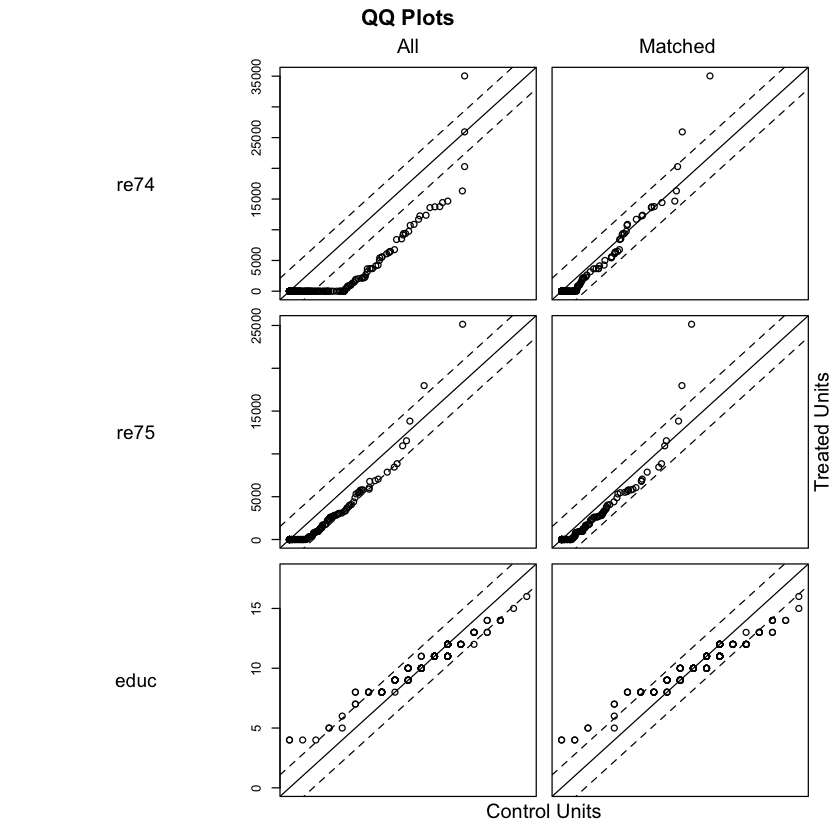

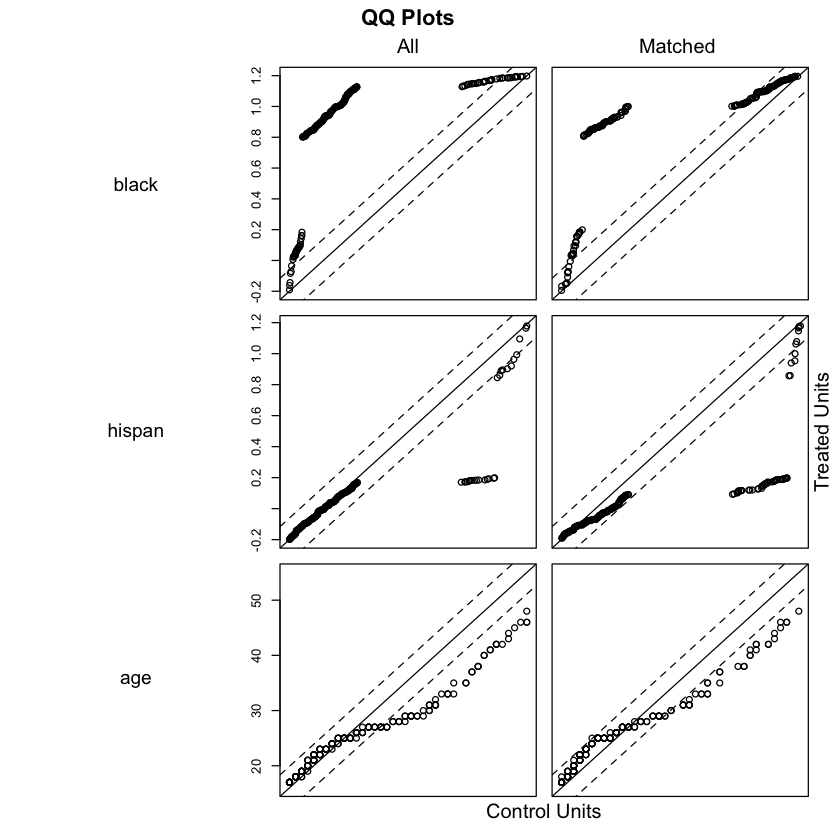

In [41]:
plot(m.out) # not sure how to interpret the result

[1] "To identify the units, use first mouse button; to stop, use second."


integer(0)

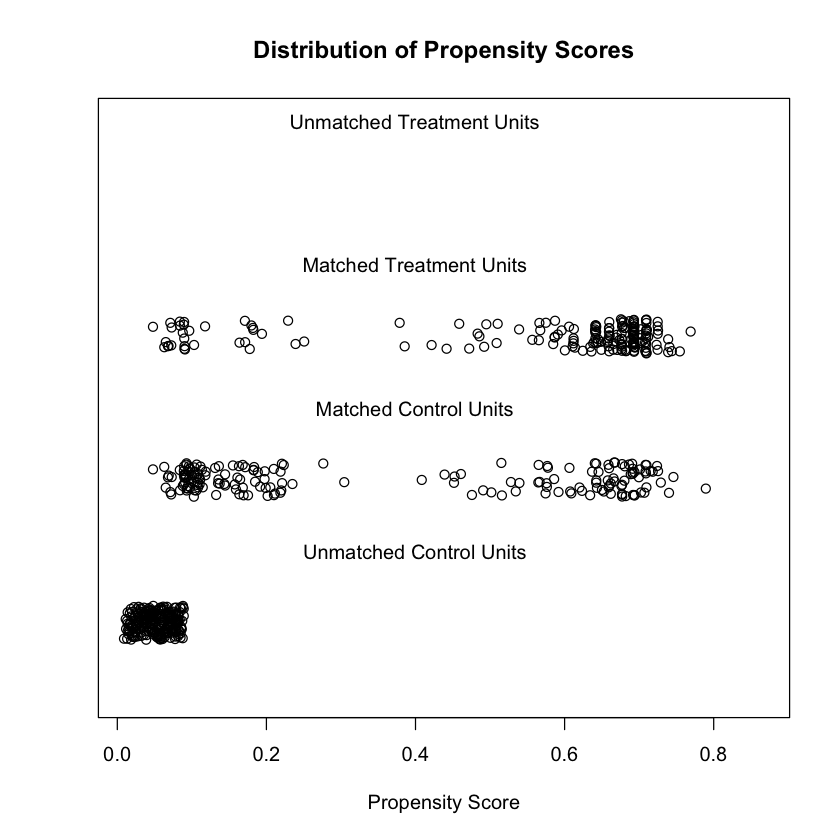

In [43]:
# shows the distribution of unmatched and matched pairs for both treatment and control groups
plot(m.out, type = "jitter")

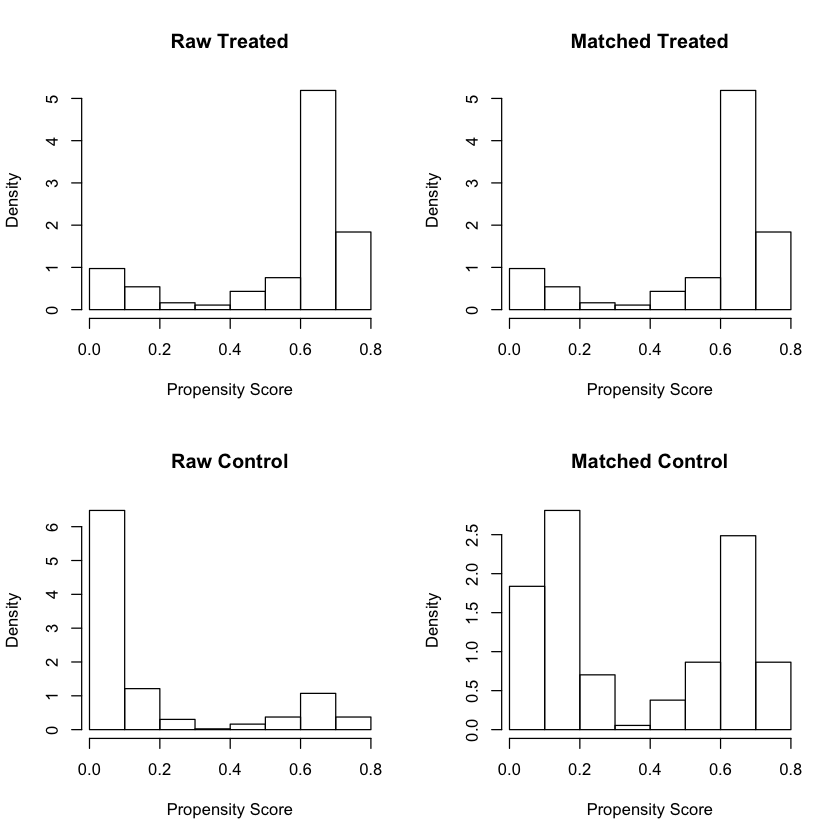

In [44]:
plot(m.out, type = "hist")

#### <a id='analysis'>Conducting Analyses after Matching</a>

* [Zelig Quick Start](http://docs.zeligproject.org/articles/quickstart.html)
* [Zelig Examples](https://r.iq.harvard.edu/docs/matchit/2.4-20/Examples2.html)

After going through the matching process, we have a data set matched treatment and control. We can then use this dataset to estimate the causal impact of our variable of interest. 

There are several ways we can do to estimate the impact of participating in the program to the real earning in 1978.

1. **Univariate calculation**: Calculate the mean difference directly using the new data set. Not an ideal approach.
2. **Model-Based Estimates**: Compute quantities of interest in the most common way. Fit model and use the model coefficient to estimate the impact, this can be done manually (for example, fit lm model, get the estimation by changing the feature value, and get the confidence interval of the point estimation). Luckily, this is basically what Zelig package can help us do. 
3. **Model-Based Estimates by estimating the coefficients in the control group alone**: similar to approach 2. The main difference is that the coefficient is estimated by fitting a model using the records in the control group alone. When estimating the treatment effect, we use the coefficients estimated in this way from the control group, and combine them with the values of the covariates set to the values of the treated units. We get the final estimate by calculating conditional prediction. 
4. **Model-Based Estimates by estimating the coefficients in the treatment group alone**: similar to approach 2. The main difference is that the coefficient is estimated by fitting a model using the records in the treatment group alone.



All All models in Zelig can be estimated and results explored presented using four simple functions:
1. **zelig**" to estimate the parameters,
2. **setx**" to set fitted values for which we want to find quantities of interest,
3. **sim**: to simulate the quantities of interest,
4. **plot**: to plot the simulation results.

In [19]:
library(Zelig)

Warning message:
“package ‘Zelig’ was built under R version 3.4.3”Loading required package: survival


In [89]:
m.data <- match.data(m.out)
head(m.data)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,distance,weights
NSW1,1,37,11,1,0,1,1,0,0,9930.0460,0.6387699,1
NSW2,1,22,9,0,1,0,1,0,0,3595.8940,0.2246342,1
NSW3,1,30,12,1,0,0,0,0,0,24909.4500,0.6782439,1
NSW4,1,27,11,1,0,0,1,0,0,7506.1460,0.7763241,1
NSW5,1,33,8,1,0,0,1,0,0,289.7899,0.7016387,1
NSW6,1,22,9,1,0,0,1,0,0,4056.4940,0.6990699,1


In [108]:
# The average increase of real earning in 1978 is ~908
m.data %>% group_by(treat) %>% summarise(mean(re78))

treat,mean(re78)
0,5440.941
1,6349.144


> **2. Model-Based Estimates**

In our first example, we conduct a standard parametric analysis and compute quantities of interest in the most common way. We begin with nearest neighbor matching with a logistic regression-based propensity score:

In [86]:
# we've done this in the previous step.
m.out <- matchit(treat ~ age + educ + black + hispan + nodegree + married + re74 + re75, 
                 method = "nearest", 
                 data = lalonde)

Then we check balance using the summary and plot procedures (which we don't show here). When the best balance is achieved, we run the parametric analysis:

In [74]:
z.out <- zelig(re78 ~ treat + age + educ + black + hispan + nodegree + married + re74 + re75, 
               data = match.data(m.out), 
               model = "ls")
z.out

How to cite this model in Zelig:
  R Core Team. 2007.
  ls: Least Squares Regression for Continuous Dependent Variables
  in Christine Choirat, Christopher Gandrud, James Honaker, Kosuke Imai, Gary King, and Olivia Lau,
  "Zelig: Everyone's Statistical Software," http://zeligproject.org/


Model: 

Call:
z5$zelig(formula = re78 ~ treat + age + educ + black + hispan + 
    nodegree + married + re74 + re75, data = match.data(m.out))

Residuals:
   Min     1Q Median     3Q    Max 
 -8886  -5069  -1742   3436  53482 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -2248.7617  3513.0363  -0.640  0.52250
treat        1351.9596   790.0649   1.711  0.08791
age             8.7968    42.9306   0.205  0.83776
educ          608.3103   224.1507   2.714  0.00697
black        -431.4137  1010.2924  -0.427  0.66962
hispan       1108.5720  1300.6662   0.852  0.39461
nodegree      931.6816  1110.3146   0.839  0.40196
married      -160.2103   986.6630  -0.162  0.87110
re74            0.0258     0.1030   0.251  0.80230
re75            0.2217     0.1596   1.389  0.16567

Residual standard error: 6942 on 360 degrees of freedom
Multiple R-squared:  0.04939,	Adjusted R-squared:  0.02563 
F-statistic: 2.078 on 9 and 360 DF,  p-value: 0.03069

Statistical Warning: The

and then set the explanatory variables at their means (the default) and change the treatment variable from a 0 to a 1:

In [81]:
x.out <- setx(z.out, treat=0)
x1.out <- setx(z.out, treat=1)

and finally compute the result and examine a summary:

In [82]:
s.out <- sim(z.out, x = x.out, x1 = x1.out)

In [83]:
summary(s.out)


 sim x :
 -----
ev
      mean      sd      50%    2.5%    97.5%
1 5229.671 526.086 5230.836 4185.41 6223.596
pv
         mean      sd     50%      2.5%    97.5%
[1,] 5450.163 6811.46 5573.92 -8800.338 18512.75

 sim x1 :
 -----
ev
     mean       sd      50%     2.5%    97.5%
1 6578.89 558.7307 6594.149 5466.066 7704.474
pv
         mean       sd      50%      2.5%    97.5%
[1,] 6472.546 6937.533 6353.175 -7201.102 20216.96
fd
      mean       sd      50%      2.5%    97.5%
1 1349.219 771.4476 1335.428 -146.9043 2911.052


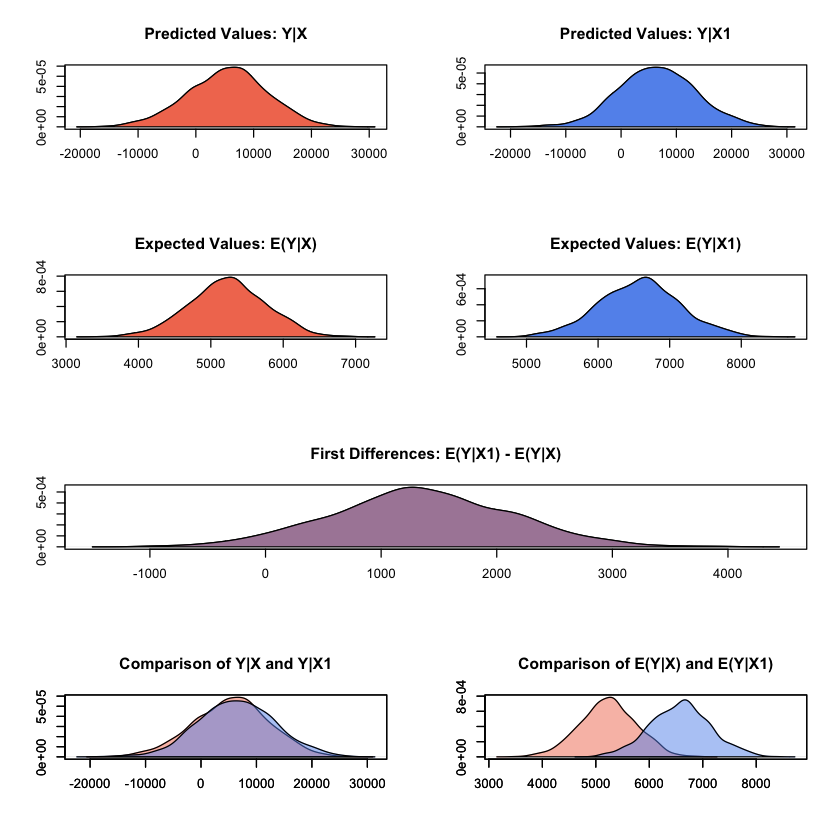

In [84]:
plot(s.out)

> **3. Model-Based Estimates by estimating the coefficients in the control group alone**

In [129]:
# not sure how to get the final estimated causal impact

m.out1 <- matchit(treat ~ age + educ + black + hispan + nodegree + 
                    married + re74 + re75, method = "nearest", data = lalonde)
# Then we check balance using the summary and plot procedures (which we don't show here). We reestimate the matching procedure until we achieve the best balance possible. (The running examples here are meant merely to illustrate, not to suggest that we've achieved the best balance.) Then we go to Zelig, and in this case choose to fit a linear least squares model to the control group only:
z.out1 <- zelig(re78 ~ age + educ + black + hispan + nodegree + 
                  married + re74 + re75, data = match.data(m.out1, "control"), 
                  model = "ls")
# where the "control" option in match.data() extracts only the matched control units and ls specifies least squares regression. In a smaller data set, this example should probably be changed to include all the data in this estimation (using data = match.data(m.out1) for the data) and by including the treatment indicator (which is excluded in the example since its a constant in the control group.) 
# Next, we use the coefficients estimated in this way from the control group, and combine them with the values of the covariates set to the values of the treated units. We do this by choosing conditional prediction (which means use the observed values) in setx(). The sim() command does the imputation.
x.out1 <- setx(z.out1, data = match.data(m.out1, "treat"), cond = TRUE)

s.out1 <- sim(z.out1, x = x.out1)
# Finally, we obtain a summary of the results by
summary(s.out1)

How to cite this model in Zelig:
  R Core Team. 2007.
  ls: Least Squares Regression for Continuous Dependent Variables
  in Christine Choirat, Christopher Gandrud, James Honaker, Kosuke Imai, Gary King, and Olivia Lau,
  "Zelig: Everyone's Statistical Software," http://zeligproject.org/

 sim x :
 -----
ev
      mean       sd     50%     2.5%    97.5%
1 5447.576 424.1033 5436.55 4617.606 6243.685
pv
        mean       sd      50%      2.5%    97.5%
[1,] 5503.96 5832.273 5491.911 -6284.359 17023.93


> **4. Model-Based Estimates by estimating the coefficients in the treatment group alone**

In [132]:
# not sure how to get the final estimated causal impact

# To estimate the average treatment effect, we continue with the previous example and fit the linear model to the treatment group:
z.out2 <- zelig(re78 ~ age + educ + black + hispan + nodegree + 
                  married + re74 + re75, data = match.data(m.out1, "treat"), 
                  model = "ls")
# We then conduct the same simulation procedure in order to impute the counterfactual outcome for the control group,
x.out2 <- setx(z.out2, data = match.data(m.out1, "control"), cond = TRUE)
s.out2 <- sim(z.out2, x = x.out2)

summary(s.out2)
# # In this calculation, Zelig is computing the difference between observed and the expected values. This means that the treatment effect for the control units is the effect of control (observed control outcome minus the imputed outcome under treatment from the model). Hence, to combine treatment effects just reverse the signs of the estimated treatment effect of controls.
# ate.all <- c(s.out1$qi$att.ev, -s.out2$qi$att.ev)
# # The point estimate, its standard error, and the $ 95\%$ confidence interval is given by
# mean(ate.all)
# sd(ate.all)
# quantile(ate.all, c(0.025, 0.975))

How to cite this model in Zelig:
  R Core Team. 2007.
  ls: Least Squares Regression for Continuous Dependent Variables
  in Christine Choirat, Christopher Gandrud, James Honaker, Kosuke Imai, Gary King, and Olivia Lau,
  "Zelig: Everyone's Statistical Software," http://zeligproject.org/

 sim x :
 -----
ev
      mean       sd      50%     2.5%    97.5%
1 6326.378 567.9334 6327.261 5249.221 7425.884
pv
        mean       sd      50%      2.5%    97.5%
[1,] 6160.67 7877.771 6051.692 -8534.095 22101.99


---

**Part 2 Outline**
* [Inferring the effect of an event using CausalImpact by Kay Brodersen](#causalimpact)
    * [Introduction](#intro2)
    * [An Example](#causalimpactexample)

## <a id='causalimpact'>Inferring the effect of an event using CausalImpact by Kay Brodersen</a>

* [CausalImpact Presentation Video](https://www.youtube.com/watch?v=GTgZfCltMm8)
* [CausalImpact Documentation & Example](http://google.github.io/CausalImpact/CausalImpact.html)

**TL;DR**: there are cases when we want to estimate the casual impact of *one certain event* without running an experiment. The R pacakge **CausalImpact** can help us estimate the causal impact using time series data by estimating "what would have happen if that event were not taken". This is done by using some other feature to make a point-wise prediction and treat it as our counterfactual truth. Of course, this is based on the assumption that these features (or co-variates) were not themselves affected by the intervention.

### <a id='intro2'>Introduction</a>
A usual way to estimate causal impact is through randomize experiment. However, there are situations when an experiment can not be done:
* Too expensive
* Too difficult
* Unethical

That's when causal inference from observational data come into play.
The goal of causal impact is to estimate "what would have happen in the absense of the action whose effects were interested in".

In the language of causal inference, we have our observed data $y_1$, and all wee need to do to understand causal effects is to estimate the counterfactual $y_0$. Some people have introduced the term synthetic control, since we don't have an experiment and there isn't really a control in the experiment sense and yet we want to be able to estimate something just like a control. It's important because the difference between the coutnerfactual and the actual observed data is our causal effect.

> **Potential Outcome Framework Table**

The idea behind systheic control: We want to train a statistical model in the pre-period, and use that model to predict and generate a time-series in the post-period. Treat the predicted time series as our ground truth. The difference between our actual observed data and our predicted time series is the causal impact.

<img src="_pic/youtube_1.png" style="width: 350px;height: 200px;"/>

<img src="_pic/youtube_2.png" style="width: 350px;height: 200px;"/>

<img src="_pic/youtube_3.png" style="width: 350px;height: 200px;"/>

<img src="_pic/youtube_4.png" style="width: 350px;height: 200px;"/>

### <a id='causalimpactexample'>An example</a>

Most of the content below are copied from the documentation from this library's author.

CausalImpact 1.2.3, Brodersen et al., Annals of Applied Statistics (2015). http://google.github.io/CausalImpact/

In [2]:
library(CausalImpact)

Warning message:
“package ‘CausalImpact’ was built under R version 3.4.1”Loading required package: bsts
Warning message:
“package ‘bsts’ was built under R version 3.4.4”Loading required package: BoomSpikeSlab
Warning message:
“package ‘BoomSpikeSlab’ was built under R version 3.4.4”Loading required package: Boom
Warning message:
“package ‘Boom’ was built under R version 3.4.4”Loading required package: MASS

Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts
Warning message:
“package ‘xts’ was built under R version 3.4.1”

> **1. Creating an example dataset**

To illustrate how the package works, we create a simple toy dataset. It consists of a response variable y and a predictor x1. Note that in practice, we'd strive for including many more predictor variables and let the model choose an appropriate subset. The example data has 100 observations. We create an intervention effect by lifting the response variable by 10 units after timepoint 71.

In [3]:
set.seed(1)
x1 <- 100 + arima.sim(model = list(ar = 0.999), n = 100)
y <- 1.2 * x1 + rnorm(100)
y[71:100] <- y[71:100] + 10
data <- cbind(y, x1)

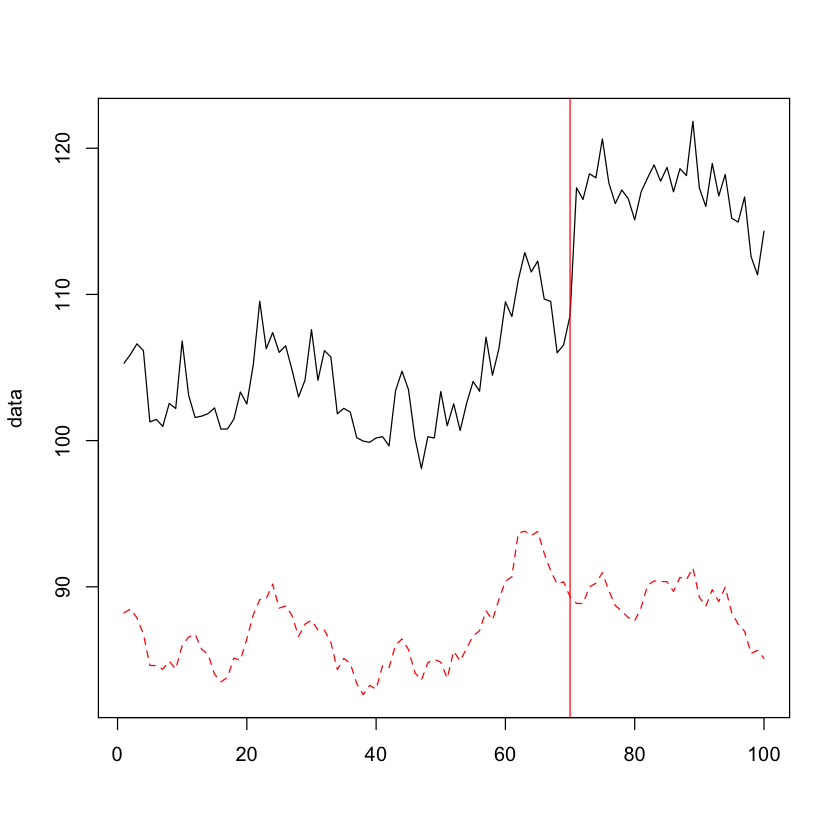

In [6]:
matplot(data, type = "l")
abline(v=70,col='red') 

> **2. Running an analysis**

To estimate a causal effect, we begin by specifying which period in the data should be used for training the model (pre-intervention period) and which period for computing a counterfactual prediction (post-intervention period).

In [7]:
pre.period <- c(1, 70)
post.period <- c(71, 100)

To perform inference, we run the analysis using:

In [8]:
impact <- CausalImpact(data, pre.period, post.period)

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

This instructs the package to assemble a structural time-series model, perform posterior inference, and compute estimates of the causal effect. The return value is a CausalImpact object.

> **3. Plotting the results**

Warning message:
“Removed 100 rows containing missing values (geom_path).”Warning message:
“Removed 200 rows containing missing values (geom_path).”

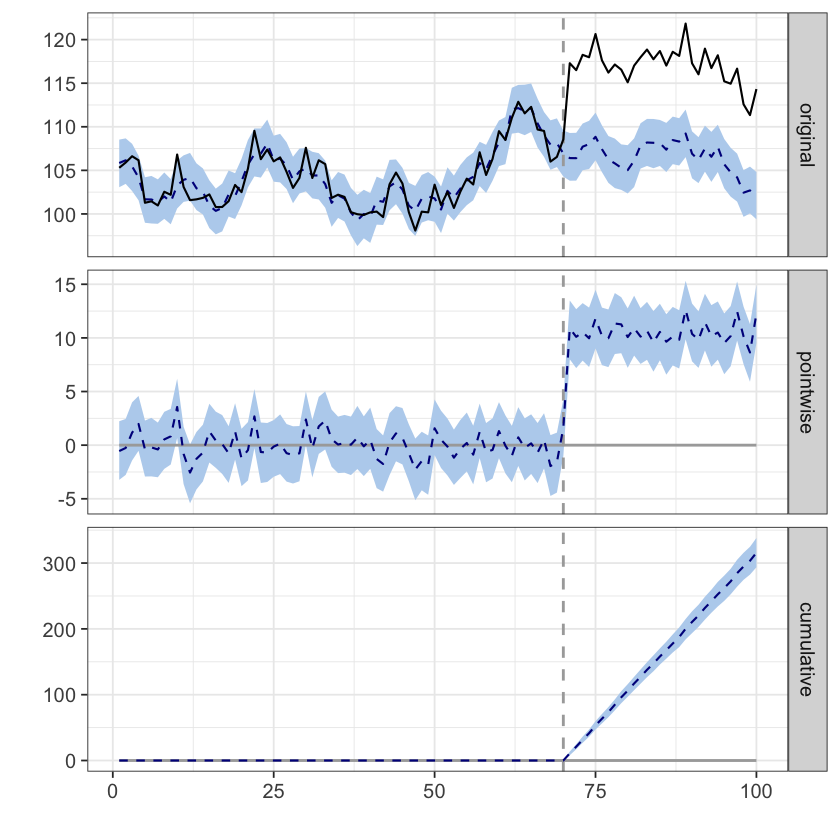

In [10]:
plot(impact)

By default, the plot contains three panels. 
* **The first panel** shows the data and a counterfactual prediction for the post-treatment period. 
* **The second panel** shows the difference between observed data and counterfactual predictions. This is the pointwise causal effect, as estimated by the model. 
* **The third panel** adds up the pointwise contributions from the second panel, resulting in a plot of the cumulative effect of the intervention.

Remember, once again, that all of the above inferences depend critically on the assumption that the covariates were not themselves affected by the intervention. The model also assumes that the relationship between covariates and treated time series, as established during the pre-period, remains stable throughout the post-period.

> **3' Working with dates and times**

It is often more natural to feed a time-series object into CausalImpact() rather than a data frame. For example, we might create a data variable as follows:

In [11]:
time.points <- seq.Date(as.Date("2014-01-01"), by = 1, length.out = 100)
data <- zoo(cbind(y, x1), time.points)
head(data)

                  y       x1
2014-01-01 105.2950 88.21513
2014-01-02 105.8943 88.48415
2014-01-03 106.6209 87.87684
2014-01-04 106.1572 86.77954
2014-01-05 101.2812 84.62243
2014-01-06 101.4484 84.60650

In [12]:
pre.period <- as.Date(c("2014-01-01", "2014-03-11"))
post.period <- as.Date(c("2014-03-12", "2014-04-10"))

As a result, the x-axis of the plot shows time points instead of indices

Warning message:
“Removed 100 rows containing missing values (geom_path).”Warning message:
“Removed 200 rows containing missing values (geom_path).”

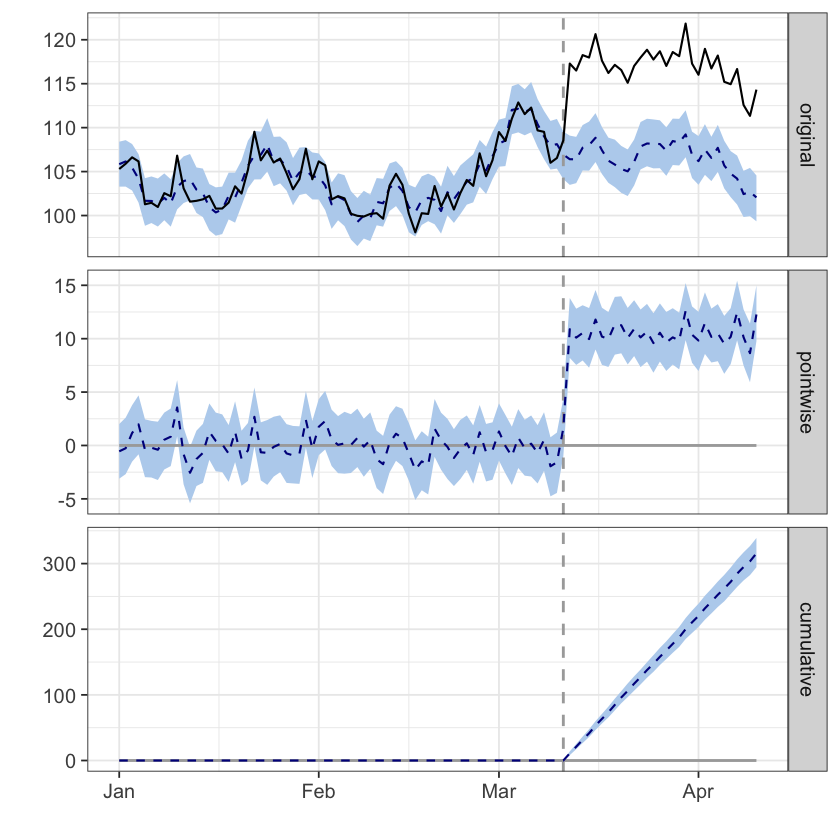

In [13]:
impact <- CausalImpact(data, pre.period, post.period)
plot(impact)

> **4. Printing a summary table**

In [14]:
summary(impact)

Posterior inference {CausalImpact}

                         Average        Cumulative  
Actual                   117            3511        
Prediction (s.d.)        107 (0.37)     3196 (11.04)
95% CI                   [106, 107]     [3172, 3217]
                                                    
Absolute effect (s.d.)   11 (0.37)      316 (11.04) 
95% CI                   [9.8, 11]      [294.4, 339]
                                                    
Relative effect (s.d.)   9.9% (0.35%)   9.9% (0.35%)
95% CI                   [9.2%, 11%]    [9.2%, 11%] 

Posterior tail-area probability p:   0.001
Posterior prob. of a causal effect:  99.8997%

For more details, type: summary(impact, "report")



The Average column talks about the average (across time) during the post-intervention period (in the example: time points 71 through 100). The Cumulative column sums up individual time points, which is a useful perspective if the response variable represents a flow quantity (such as queries, clicks, visits, installs, sales, or revenue) rather than a stock quantity (such as number of users or stock price).

In the example, the estimated average causal effect of treatment was 11 (rounded to a whole number; for full precision see impact$summary). This is because we observed an average value of 99 but would have expected an average value of only 89. The 95% posterior interval of the average effect is [9.8, 11]. Since this excludes 0, we (correctly) conclude that the intervention had a causal effect on the response variable. Since we generated the data ourselves, we know that we injected a true effect of 10, and so the model accurately recovered ground truth. One reason for this is that we ensured, by design, that the covariate x1 was not itself affected by the intervention. In practice, we must always reason whether this assumption is justified.

For additional guidance about the correct interpretation of the summary table, the package provides a verbal interpretation, which we can print using:

In [15]:
summary(impact, "report")

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 117.05. By contrast, in the absence of an intervention, we would have expected an average response of 106.52. The 95% interval of this counterfactual prediction is [105.75, 107.23]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 10.52 with a 95% interval of [9.81, 11.30]. For a discussion of the significance of this effect, see below.

Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 3.51K. By contrast, had the intervention not taken place, we would have expected a sum of 3.20K. The 95% interval of this prediction is [3.17K, 3.22K].

The above results are given in terms of absolute numbers. In relative terms, the response variable 

The individual numbers in the table, at full precision, can be accessed using:



In [16]:
impact$summary

,Actual,Pred,Pred.lower,Pred.upper,Pred.sd,AbsEffect,AbsEffect.lower,AbsEffect.upper,AbsEffect.sd,RelEffect,RelEffect.lower,RelEffect.upper,RelEffect.sd,alpha,p
Average,117.0485,106.525,105.7482,107.234,0.3680567,10.52352,9.814566,11.30034,0.3680567,0.09878919,0.09213392,0.1060816,0.003455121,0.05,0.001003009
Cumulative,3511.4555,3195.750,3172.4453,3217.019,11.0417013,315.70554,294.436978,339.01020,11.0417013,0.09878919,0.09213392,0.1060816,0.003455121,0.05,0.001003009


> **Other Caveats**

* So far, we’ve simply let the package decide how to construct a time-series model for the available data. However, there are several options that allow us to gain a little more control over this process. These options are passed into model.args as individual list elements. A list of tunable parameters are [here](http://google.github.io/CausalImpact/CausalImpact.html#adjusting-the-model)

* Instead of using the default model constructed by the CausalImpact package, we can also build the model by ourselves and specify to use it. Refer the official doc [here](http://google.github.io/CausalImpact/CausalImpact.html#using-a-custom-model) for example


## <a id='refer'>Reference</a>
* [Video: An intuitive introduction to Propensity Score Matching](https://www.youtube.com/watch?v=ACVyPp1Fy6Y)
* [Wiki: Propensity Score Matching](https://en.wikipedia.org/wiki/Propensity_score_matching)
* [Reference: Propensity Score Matching](https://sejdemyr.github.io/r-tutorials/statistics/tutorial8.html)
* [Offical MatchIt Document](https://r.iq.harvard.edu/docs/matchit/2.4-20/)
* [Zelig Quick Start](http://docs.zeligproject.org/articles/quickstart.html)
* [Zelig Examples](https://r.iq.harvard.edu/docs/matchit/2.4-20/Examples2.html)
* [CausalImpact Presentation Video](https://www.youtube.com/watch?v=GTgZfCltMm8)
* [CausalImpact Documentation & Example](http://google.github.io/CausalImpact/CausalImpact.html)
